In [56]:
import os
import pprint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import VotingClassifier

# Vizualization

In [51]:
def learn_curve(str_id, clf, X_train, X_test, y_train, y_test):
    """Get learning curve and confusion matrix
    
    Params
    -------
    str_id : Ideally name of classifier {str}
    clf : classifier {sklearn-obj}
    X_train : {numpy.array}
    X_test : {numpy.array}
    y_train : {numpy.array}
    y_test : {numpy.array}
    
    Creates two png files.
    """
    dest = os.path.join('figures')
    if not os.path.exists(dest):
        os.makedirs(dest)
    
    # get validation curve
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf,
                                   X=X_train,
                                   y=y_train,
                                   train_sizes=np.linspace(0.1, 1.0, 10),
                                   cv=10,
                                   n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')
    plt.tight_layout()
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    lc_name = str_id + 'learning_curve.png'
    plt.savefig('./figures/'+lc_name, dpi=300)
    plt.show()
    
def conf_mat(str_id, clf, X_train, X_test, y_train, y_test):
    """Get learning curve and confusion matrix
    
    Params
    -------
    str_id : Ideally name of classifier {str}
    clf : classifier {sklearn-obj}
    X_train : {numpy.array}
    X_test : {numpy.array}
    y_train : {numpy.array}
    y_test : {numpy.array}
    
    Creates two png files.
    """
    dest = os.path.join('figures')
    if not os.path.exists(dest):
        os.makedirs(dest)
    # confusion matrix
    y_pred = clf.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label', fontsize=15)
    plt.ylabel('true label', fontsize=15)

    #plt.tight_layout()
    cm_name = str_id + 'confusion_matrix.png'
    plt.savefig('./figures/'+cm_name, dpi=300)
    plt.show()

# Models

In [20]:
dest = os.path.join('pkl_objects')
gs_clf1 = pickle.load(open(os.path.join(dest, '2gs_logit.pkl'), 'rb'))
gs_clf2 = pickle.load(open(os.path.join(dest, '2gs_svc.pkl'), 'rb'))
gs_clf3 = pickle.load(open(os.path.join(dest, '2gs_nb.pkl'), 'rb'))

clf1 = gs_clf1.best_estimator_
clf2 = gs_clf2.best_estimator_
clf3 = gs_clf3.best_estimator_

print(gs_clf1.best_params_,'\n')
print(gs_clf2.best_params_,'\n')
print(gs_clf3.best_params_,'\n')

{'clf__C': 100.0, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7fc917116f28>} 

{'clf__C': 10.0, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7fc917116f28>} 

{'clf__alpha': 0.25, 'vect__ngram_range': (1, 2), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7fc917116f28>, 'vect__use_idf': False} 



# Visualizing Results

In [25]:
f_authorship = 'users/authorship.csv'

df = pd.read_csv(f_authorship)
df.drop_duplicates()

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

X = df.loc[:, 'text'].values
y = df.loc[:, 'user_id'].values
le = LabelEncoder()
y = le.fit_transform(y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)

In [26]:
print('CV Acc.: {:.3f} \t Test Acc.: {:.3f}'.format(gs_clf1.best_score_, clf1.score(X_test, y_test)))
print('CV Acc.: {:.3f} \t Test Acc.: {:.3f}'.format(gs_clf2.best_score_, clf2.score(X_test, y_test)))
print('CV Acc.: {:.3f} \t Test Acc.: {:.3f}'.format(gs_clf3.best_score_, clf3.score(X_test, y_test)))

CV Acc.: 0.980 	 Test Acc.: 0.999
CV Acc.: 0.979 	 Test Acc.: 0.999
CV Acc.: 0.971 	 Test Acc.: 0.992


In [29]:
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('nb', clf3)], voting='hard')
eclf = eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.989


## Logistic Regression

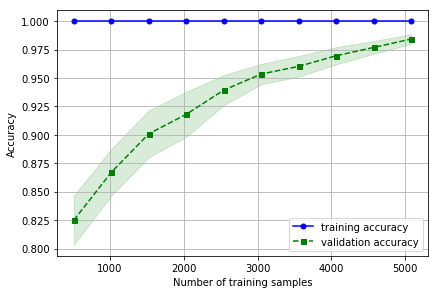

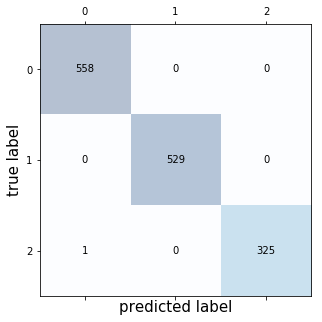

In [53]:
learn_curve('lr', clf1, X_train, X_test, y_train, y_test)
conf_mat('lr', clf1, X_train, X_test, y_train, y_test)

## SVC

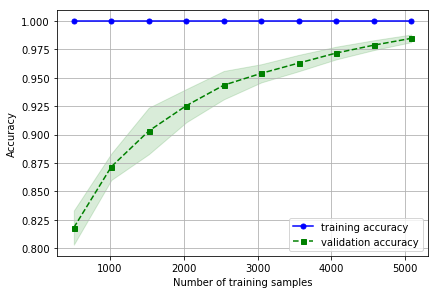

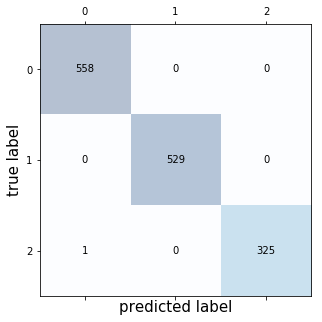

In [54]:
learn_curve('svc', clf2, X_train, X_test, y_train, y_test)
conf_mat('svc', clf2, X_train, X_test, y_train, y_test)

## Naive Bayes

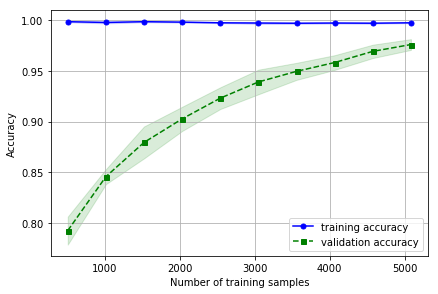

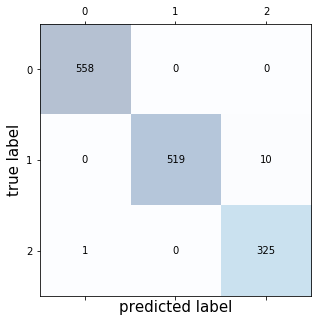

In [52]:
learn_curve('nb', clf3, X_train, X_test, y_train, y_test)
conf_mat('nb', clf3, X_train, X_test, y_train, y_test)

## Majority Vote 

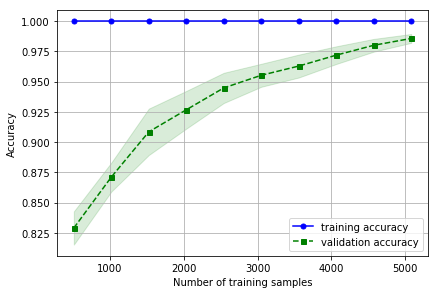

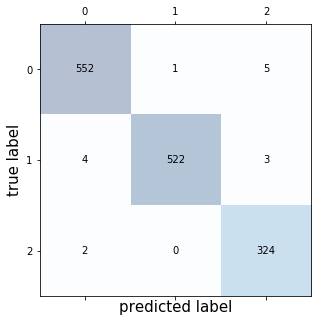

In [55]:
learn_curve('eclf', eclf, X_train, X_test, y_train, y_test)
conf_mat('eclf', eclf, X_train, X_test, y_train, y_test)